In [1]:
from firedrake import *
from firedrake.pyplot import FunctionPlotter, tripcolor
import math
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import sys
from irksome import GaussLegendre, Dt, MeshConstant, TimeStepper



firedrake:WARNING OMP_NUM_THREADS is not set or is set to a value greater than 1, we suggest setting OMP_NUM_THREADS=1 to improve performance


In [2]:
Nx = 10
Ny = 10
Lx = 1.
Ly = 1.

nsp = 5

mesh = UnitSquareMesh(Nx, Ny)

In [3]:
V = FunctionSpace(mesh, "CG", 2)
W = FunctionSpace(mesh, "RTE", 2)

Q = V * W

In [4]:
x, y = SpatialCoordinate(mesh)

In [5]:
up = Function(Q)
myu = Function(V).interpolate(sin(pi * x) ** 6 * sin(pi * y) ** 6)
myp = Function(W).interpolate(as_vector([0., 0.]))
up.sub(0).assign(myu)
up.sub(1).assign(myp)
up_init = up.copy(deepcopy=True)

In [6]:
ups = []

In [7]:
T = 2.5
dt = T/1600.0
dtc = Constant(dt)

In [8]:
du, dp = TrialFunctions(Q)
sigma, tau = TestFunctions(Q)

a = (sigma * du + dot(tau, dp))*dx

In [9]:
n = FacetNormal(mesh)

In [10]:
L1 = dtc*(dot(grad(sigma), up.sub(1)) - dot(grad(up.sub(0)),tau))*dx

In [11]:
bcs = DirichletBC(Q.sub(0), 0., [1, 2, 3, 4])

In [12]:
up1 = Function(Q); up2 = Function(Q); up3 = Function(Q)
L2 = replace(L1, {up: up1})
L3 = replace(L1, {up: up2})
L4 = replace(L1, {up: up3})

In [13]:
E = 0.5 * (inner(up.sub(0), up.sub(0))*dx + inner(up.sub(1), up.sub(1))*dx)
Es = [assemble(E)]
Ts = [0.0]

In [14]:
dup = Function(Q)

In [15]:
params = {'ksp_type': 'preonly', 'pc_type': 'bjacobi', 'sub_pc_type': 'ilu'}
prob1 = LinearVariationalProblem(a, L1, dup, bcs = bcs)
solv1 = LinearVariationalSolver(prob1, solver_parameters=params)
prob2 = LinearVariationalProblem(a, L2, dup, bcs = bcs)
solv2 = LinearVariationalSolver(prob2, solver_parameters=params)
prob3 = LinearVariationalProblem(a, L3, dup, bcs = bcs)
solv3 = LinearVariationalSolver(prob3, solver_parameters=params)
prob4 = LinearVariationalProblem(a, L4, dup, bcs = bcs)
solv4 = LinearVariationalSolver(prob3, solver_parameters=params)

In [16]:
t = 0.0
step = 0
output_freq = 15
while t < T - 0.5*dt:
    solv1.solve()
    up1.assign(up + dup / 2)
    dup1 = dup.copy(deepcopy=True)

    solv2.solve()
    up2.assign(up + dup / 2)
    dup2 = dup.copy(deepcopy=True)

    solv3.solve()
    up3.assign(up + dup)
    dup3 = dup.copy(deepcopy=True)

    solv4.solve()
    up.assign(up + (dup1 / 6 + dup2 / 3 + dup3 / 3 + dup / 6) / 2.)

    step += 1
    t += dt

    if step % output_freq == 0:
        ups.append(up.copy(deepcopy=True))
        Es.append(assemble(E))
        Ts.append(t)
#        print(Es[-1])
#        print("t=", t)

In [17]:
nsp = 16
fn_plotter = FunctionPlotter(mesh, num_sample_points=nsp)

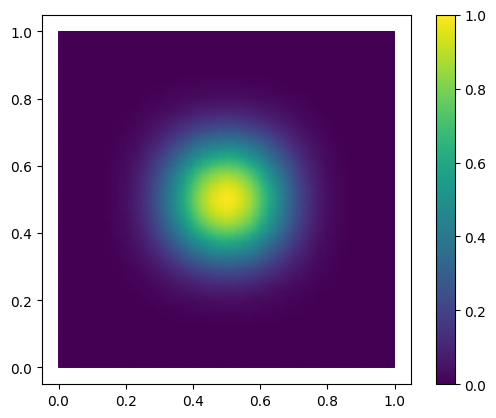

In [18]:
fig, axes = plt.subplots()
axes.set_aspect('equal')
colors = tripcolor(up_init.sub(0), num_sample_points=nsp, vmin=0, vmax=1, axes=axes)
fig.colorbar(colors)

In [19]:
def animate(q):
    colors.set_array(fn_plotter(q.sub(0)))

In [20]:
interval = 3 * 1e3 * output_freq * dt
animation = FuncAnimation(fig, animate, frames=ups, interval=interval)
try:
    animation.save("H1WaveRK4Dirichlet.mp4", writer="ffmpeg")
except:
    print("Failed to write movie! Try installing `ffmpeg`.")

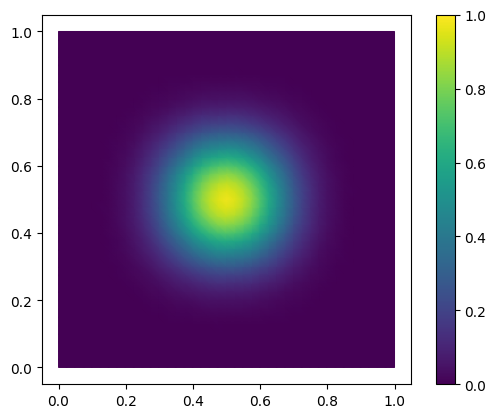

In [21]:
fig, axes = plt.subplots()
axes.set_aspect('equal')
colors = tripcolor(ups[1].sub(0), num_sample_points=nsp, vmin=0, vmax=1, axes=axes)
fig.colorbar(colors)

In [22]:
HTML(animation.to_html5_video())

In [23]:
up0 = project(as_vector([sin(pi*x) ** 6 *sin(pi*y) ** 6, 0, 0]), Q)
u0, p0 = split(up0)
up_initIrk = up0.copy(deepcopy=True)

In [24]:
upsIrk = [up_init]

In [25]:
sigma, tau = TestFunctions(Q)
F = inner(Dt(u0), sigma)*dx - inner(p0,grad(sigma)) * dx + inner(Dt(p0), tau)*dx + inner(tau, grad(u0)) * dx

In [26]:
EIrk = 0.5 * (inner(u0, u0)*dx + inner(p0, p0)*dx)
EsIrk = [assemble(EIrk)]
tsIrk = [0.0]

In [27]:
MC = MeshConstant(mesh)
tIrk = MC.Constant(0.0)
dtIrk = MC.Constant(1.0/1600.0)

In [28]:
butcher_tableau = GaussLegendre(2)

In [29]:
params = {"mat_type": "aij",
          "snes_type": "ksponly",
          "ksp_type": "preonly",
          "pc_type": "lu"}

stepper = TimeStepper(F, butcher_tableau, tIrk, dtIrk, up0,
                      solver_parameters=params, bcs = bcs)

In [30]:
while (float(tIrk) < T - 0.5*float(dtIrk)):

    stepper.advance()

    tIrk.assign(float(tIrk) + float(dtIrk))
#    print("{0:1.1e} {1:5e}".format(float(tIrk), assemble(EIrk)))

    step += 1
    
    if step % output_freq == 0:
        upsIrk.append(up0.copy(deepcopy=True))
        EsIrk.append(assemble(EIrk))
        tsIrk.append(float(tIrk))

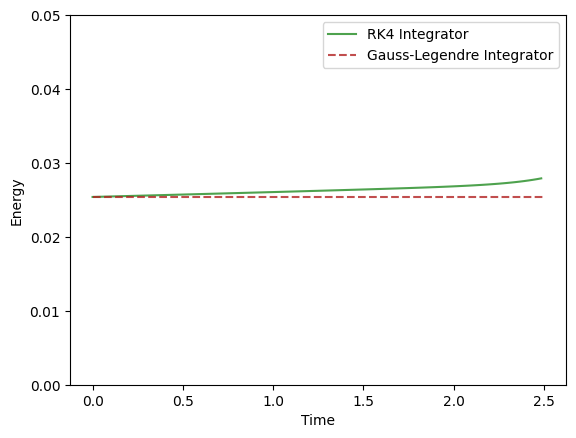

In [31]:
fig, ax = plt.subplots(1)
ax.plot(Ts, Es, label = "RK4 Integrator", c = "forestgreen", alpha = 0.8)
ax.plot(tsIrk, EsIrk, label = "Gauss-Legendre Integrator", c = "firebrick", alpha = 0.8,  linestyle='--')
ax.set_ylim(0, 0.05)
ax.set_xlabel("Time")
ax.set_ylabel("Energy")
ax.legend()

In [32]:
fig.savefig("ScalarWaveEqEnergy.png")

In [33]:
xplot = np.linspace(0, Lx, Nx * nsp)
yplot = np.linspace(0, Ly, Ny * nsp)

def cartesian_product(*arrays):
    la = len(arrays)
    dtype = np.result_type(*arrays)
    arr = np.empty([len(a) for a in arrays] + [la], dtype=dtype)
    for i, a in enumerate(np.ix_(*arrays)):
        arr[...,i] = a
    return arr.reshape(-1, la)

XY = cartesian_product(xplot, yplot)
Xmesh, Ymesh = g = np.meshgrid(xplot, yplot)
#g = np.meshgrid(xplot, yplot)
#positions = np.append(g[0].reshape(-1,1),g[1].reshape(-1,1),axis=1)
#points = np.reshape(, (Nx * nsp, Ny * nsp, 2))

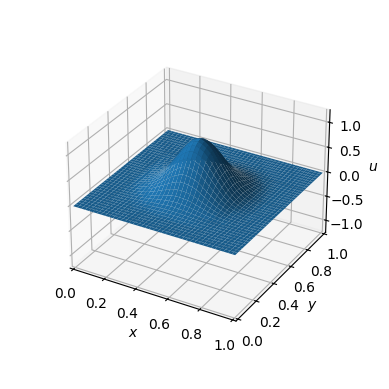

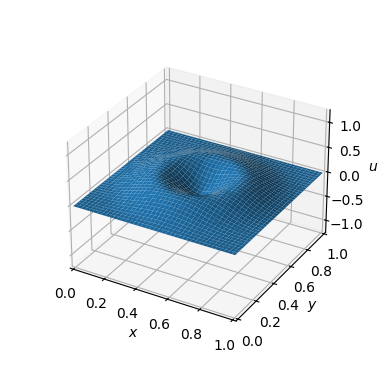

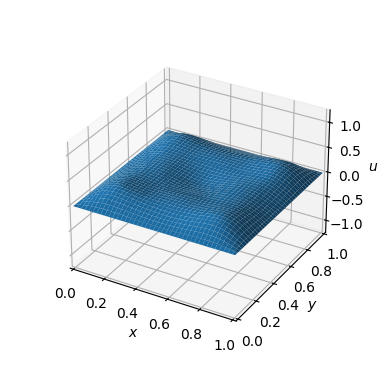

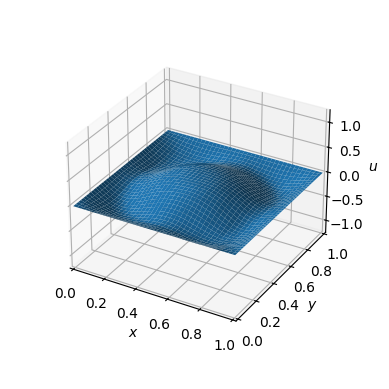

In [34]:
%matplotlib inline
len(upsIrk)
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')

u = np.reshape(np.array(upsIrk[0].sub(0).at(cartesian_product(xplot, yplot))), (Ny * nsp, Nx * nsp))


ax.plot_surface(Xmesh, Ymesh, u)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_zlim([-1.2, 1.2])
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.set_zlabel("$u$")
ax.set_box_aspect(aspect=None, zoom=0.8)

fig.savefig("ScalarWaveIrkT" + str(tsIrk[0]) + ".png", bbox_inches = 'tight', pad_inches = 0)

fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')

u = np.reshape(np.array(upsIrk[20].sub(0).at(cartesian_product(xplot, yplot))), (Ny * nsp, Nx * nsp))


ax.plot_surface(Xmesh, Ymesh, u)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_zlim([-1.2, 1.2])
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.set_zlabel("$u$")
ax.set_box_aspect(aspect=None, zoom=0.8)

fig.savefig("ScalarWaveIrkT" + str(tsIrk[20]) + ".png", bbox_inches = 'tight', pad_inches = 0)


fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')

u = np.reshape(np.array(upsIrk[160].sub(0).at(cartesian_product(xplot, yplot))), (Ny * nsp, Nx * nsp))


ax.plot_surface(Xmesh, Ymesh, u)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_zlim([-1.2, 1.2])
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.set_zlabel("$u$")
ax.set_box_aspect(aspect=None, zoom=0.8)

fig.savefig("ScalarWaveIrkT" + str(tsIrk[160]) + ".png", bbox_inches = 'tight', pad_inches = 0)

fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')

u = np.reshape(np.array(upsIrk[267].sub(0).at(cartesian_product(xplot, yplot))), (Ny * nsp, Nx * nsp))


ax.plot_surface(Xmesh, Ymesh, u)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_zlim([-1.2, 1.2])
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.set_zlabel("$u$")
ax.set_box_aspect(aspect=None, zoom=0.8)

fig.savefig("ScalarWaveIrkT" + str(tsIrk[267]) + ".png", bbox_inches = 'tight', pad_inches = 0)

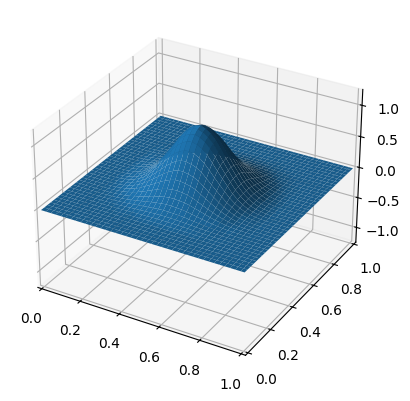

In [35]:
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')

def init():
    return fig,

def update(frame, sol, ax):
    ax.clear()

    u = np.reshape(np.array(sol[frame].sub(0).at(cartesian_product(xplot, yplot))), (Ny * nsp, Nx * nsp))
    

    ax.plot_surface(Xmesh, Ymesh, u)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_zlim([-1.2, 1.2])

    return fig,

ani = FuncAnimation(fig, update, frames=len(tsIrk), fargs=(upsIrk, ax))
